### SimCLR attempt using Convolution Net

In [1]:
import os
os.environ["LD_LIBRARY_PATH"]='/opt/conda/lib'
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/opt/conda/pkgs/cuda-toolkit"

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import tensorflow as tf
import tensorflow.keras as keras

2023-11-18 19:23:35.440410: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-18 19:23:35.472970: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-18 19:23:36.167793: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
tf.config.set_visible_devices(tf.config.get_visible_devices()[0:2])
#tf.config.set_visible_devices(tf.config.get_visible_devices()[0:3:2])
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.mnist.load_data()
# x_train = x_train.astype('float32').reshape(x_train.shape+(1,))
x_train = x_train / 255.0 
x_val = x_val / 255.0

In [5]:
x_train.shape

(60000, 28, 28)

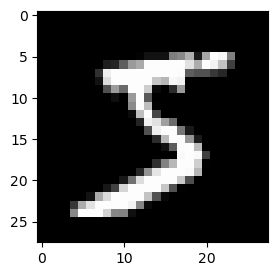

5

In [6]:
plt.figure(figsize=(3, 3))
plt.imshow(x_train[0], cmap="gray")
plt.show()
y_train[0]

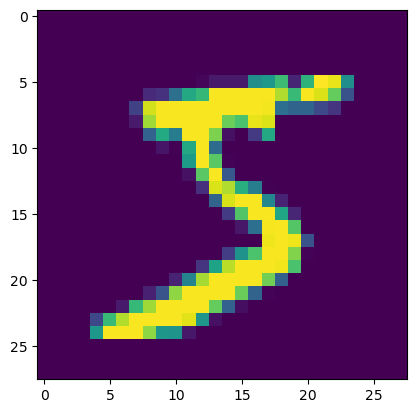

(28, 28)

In [7]:
a = x_train[0]
a.shape
plt.imshow(a)
plt.show()
a.shape

In [8]:
# def crop_and_resize(image):
#     crop_percent = np.random.uniform(0.5, 1)

#     if crop_percent == 1:
#         return image
        
#     # Get width and height from the image shape
#     width = image.shape[0]
#     height = image.shape[1]

#     # Create new dimensions for the image
#     crop_width = int(width * crop_percent)
#     crop_height = int(height * crop_percent)
#     print(crop_width, crop_height, '\n')

#     cropped = tf.image.random_crop(image, (crop_width, crop_height, 1))
#     cropped = tf.image.resize(cropped, (image.shape[0], image.shape[1]))
#     return cropped

# b = crop_and_resize(a)
# b.shape
# plt.imshow(b)
# plt.show()
# a.shape

In [9]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, x, y, batch_size=32, num_batches=100, rng: np.random.Generator = np.random.default_rng(), min_crop = .5, max_crop = 1):
        super().__init__()

        # Group by labels
        groups = [[] for _ in range(len(np.unique(y)))]
        for x_i, y_i in zip(x, y):
            groups[y_i].append(x_i)
        groups = list(map(np.array, groups))

        self.groups = groups
        self.batch_size = batch_size
        self.num_batches = num_batches
        self.rng = rng

        self.min_crop = min_crop
        self.max_crop = max_crop

        self.shuffle()

    def shuffle(self):
        self.labels = self.rng.integers(len(self.groups), size=(self.num_batches, self.batch_size))   # Which labels to draw
        self.variants = self.rng.uniform(size=(self.num_batches, 2, self.batch_size)) # Which variant of the label

    # Function to randomly crop the image
    def crop_and_resize(self, image):
        crop_percent = np.random.uniform(self.min_crop, self.max_crop)
    
        if crop_percent == 1:
            return image
            
        # Get width and height from the image shape
        width = image.shape[0]
        height = image.shape[1]
    
        # Create new dimensions for the image
        crop_width = int(width * crop_percent)
        crop_height = int(height * crop_percent)
    
        cropped = tf.image.random_crop(tf.expand_dims(image,-1), (crop_width, crop_height, 1))
        cropped = tf.squeeze(tf.image.resize(cropped, image.shape))
        
        return cropped


    def __getitem__(self, batch_index):
        batch = ([], [])
        for label, variant_a, variant_b in zip(self.labels[batch_index], *self.variants[batch_index]):
            group = self.groups[label]
            variant_a_index = int(len(group)*variant_a)
            # Instead of using two different batches, use the same with different augmentations:
            image_a = self.crop_and_resize(group[variant_a_index])
            image_b = self.crop_and_resize(group[variant_a_index])

            batch[0].append(image_a)
            batch[1].append(image_b)
            
        return tuple(np.array(batch)) # batch

    def __len__(self):
        return self.num_batches

    def on_epoch_end(self):
        self.shuffle()

2023-11-18 19:23:37.845779: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 647 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:68:00.0, compute capability: 7.5


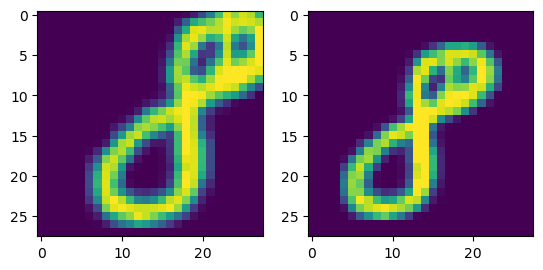

(28, 28)

In [10]:
# Generator Testing/Debugging
# [batch, x/y, set, image]
data = DataGenerator(x_train, y_train, rng=np.random.default_rng(0), min_crop = 0.4, max_crop = 1)
batch_index = 0
index = 0
plt.subplot(121)
plt.imshow(data[batch_index][0][index])
plt.subplot(122)
plt.imshow(data[batch_index][1][index])
plt.show()
data[batch_index][0][index].shape

### Sequential Model

In [11]:
x_train.shape

(60000, 28, 28)

In [12]:
x_train_reshape = x_train.astype('float32').reshape(x_train.shape+(1,))
x_train_reshape.shape

(60000, 28, 28, 1)

In [13]:
y_train_reshape = keras.utils.to_categorical(y_train, len(np.unique(y_train)))
y_train_reshape.shape

(60000, 10)

In [14]:
model = keras.Sequential()
# Note the input size (there is only one channel - intensity)
# these images... if you are using color images, your would
# need to set the last dimension of the input_shape to -3-
# above and this would carry over into this cell...
model.add(keras.layers.Conv2D(64, kernel_size=(8, 8),
                              activation='relu',
                              input_shape=[x_train_reshape.shape[1],
                                           x_train_reshape.shape[2],
                                           x_train_reshape.shape[3]]))
model.add(keras.layers.Conv2D(128, (8, 8), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(keras.layers.Conv2D(128, (2, 2), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(y_train_reshape.shape[1], activation='softmax'))

masked_encoder = model
unmasked_encoder = model

### Note: This metric only *correlates* with accuracy

This is an approximate accuracy which doesn't really track the model's actual performance, and is just used here as a metric to show progress.

In [15]:
accuracy = keras.metrics.SparseCategoricalAccuracy()
def ContrastiveAccuracy(y_true, y_pred):
    # return accuracy(y_true[tf.argmax(y_pred,-1)],
    #                 y_pred)
    acc_masked = accuracy(y_true, y_pred)
    acc_unmasked = accuracy(y_true, tf.transpose(y_pred))
    acc = (acc_masked + acc_unmasked) / 2.0
    return acc

In [16]:
class ContrastiveModel(tf.keras.Model):
    def __init__(
        self,
        masked_encoder: tf.keras.Model,
        unmasked_encoder: tf.keras.Model,
        embed_dim: int = 512,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.masked_encoder = masked_encoder
        self.unmasked_encoder = unmasked_encoder

#         self.masked_encoder.trainable = False
#         self.unmasked_encoder.trainable = False

        self.embed_dim = embed_dim
        self.W_masked = tf.keras.layers.Dense(
            self.embed_dim,
            # input_shape=self.masked_encoder.output_shape[-1],
            use_bias=False)
        self.W_unmasked = tf.keras.layers.Dense(
            self.embed_dim,
            # input_shape=self.unmasked_encoder.output_shape[-1],
            use_bias=False)
        self.t = self.add_weight(
            name="Temperature",
            shape=None,
            trainable=True
        )

    def compile(self, *args, **kwargs):
        return super().compile(
            *args,
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            **kwargs)

    def test_step(self, data):
        n = tf.shape(data[0])[0]
        y_true = tf.range(n)
        y_pred = self(data, training=False)
        loss_masked = self.compiled_loss(y_true, y_pred)
        loss_unmasked = self.compiled_loss(y_true, tf.transpose(y_pred))
        loss = (loss_masked + loss_unmasked) / 2.0
        self.compiled_metrics.update_state(y_true, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def train_step(self, data):
        n = tf.shape(data[0])[0]
        y_true = tf.range(n)
        with tf.GradientTape() as tape:
            y_pred = self(data, training=True)
            loss_masked = self.compiled_loss(y_true, y_pred)
            loss_unmasked = self.compiled_loss(y_true, tf.transpose(y_pred))
            loss = (loss_masked + loss_unmasked) / 2.0
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.compiled_metrics.update_state(y_true, y_pred)
        return {m.name: m.result() for m in self.metrics}

    def call(self, inputs, training=False):
        # Get the images from input
        masked_images, unmasked_images = inputs[0], inputs[1]

        # Embed them using the encoders
        masked_features = self.masked_encoder(masked_images)
        unmasked_features = self.unmasked_encoder(unmasked_images)

        # Joint multimodal embedding
        masked_embeddings = self.W_masked(masked_features)
        unmasked_embeddings = self.W_unmasked(unmasked_features)

        # Normalize
        masked_embeddings = masked_embeddings / tf.norm(masked_embeddings)
        unmasked_embeddings = unmasked_embeddings / tf.norm(unmasked_embeddings)

        logits = tf.tensordot(masked_embeddings, tf.transpose(unmasked_embeddings), axes=1) * tf.exp(self.t)

        return logits

In [17]:
cm = ContrastiveModel(masked_encoder, unmasked_encoder)
cm.compile(
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[
        ContrastiveAccuracy
    ],
    run_eagerly=False # Set to true to debug
)

In [18]:
data[0][1][:4].shape

(4, 28, 28)

In [19]:
cm((data[0][0][:4],data[0][1][:4]))

2023-11-18 19:23:38.821530: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8800


<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[-0.00069009, -0.00072892, -0.00077364, -0.00071273],
       [-0.00067259, -0.00070977, -0.00075384, -0.00069391],
       [-0.00055697, -0.00059492, -0.00063852, -0.00057727],
       [-0.00070162, -0.00073847, -0.00078363, -0.00072317]],
      dtype=float32)>

In [20]:
training_data = DataGenerator(x_train, y_train, batch_size=32, rng=np.random.default_rng(0), min_crop = 0.4, max_crop = 1)
# No cropping
validation_data = DataGenerator(x_val, y_val, batch_size=32, rng=np.random.default_rng(0), min_crop = 1, max_crop = 1)

In [21]:
len(training_data[0][0])

32

In [22]:
cm(validation_data[0])

<tf.Tensor: shape=(32, 32), dtype=float32, numpy=
array([[-6.0156734e-05, -5.5890872e-05, -5.3714986e-05, ...,
        -5.0444643e-05, -5.9608104e-05, -5.1897161e-05],
       [-7.2012786e-05, -6.7957721e-05, -6.5984845e-05, ...,
        -6.2670115e-05, -7.1701892e-05, -6.4185850e-05],
       [-7.2852461e-05, -6.8775837e-05, -6.6833694e-05, ...,
        -6.3487467e-05, -7.2708572e-05, -6.5027736e-05],
       ...,
       [-7.8197656e-05, -7.4120326e-05, -7.2150389e-05, ...,
        -6.8773996e-05, -7.8027108e-05, -7.0316761e-05],
       [-6.7379777e-05, -6.3393483e-05, -6.1337385e-05, ...,
        -5.7972804e-05, -6.7167282e-05, -5.9585243e-05],
       [-9.6749020e-05, -9.2879600e-05, -9.1043563e-05, ...,
        -8.7634027e-05, -9.6816206e-05, -8.9221510e-05]], dtype=float32)>

In [23]:
ContrastiveAccuracy(np.arange(validation_data[0][0].shape[0]),cm(validation_data[0]))

<tf.Tensor: shape=(), dtype=float32, numpy=0.03125>

In [24]:
callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", mode = 'min', patience = 15)
history = cm.fit(training_data,
                 epochs=300,
                 verbose=1,
                 validation_data=validation_data,
                 callbacks=[callback]
                )

Epoch 1/300


2023-11-18 19:23:39.934861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-11-18 19:23:41.402449: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape incontrastive_model/sequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-11-18 19:23:41.789809: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fd04403e430 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-18 19:23:41.790104: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-11-18 19:23:41.794569: I tensorflo

100/100 [==============================] - ETA: 0s - loss: 3.4657 - ContrastiveAccuracy: 0.0322

2023-11-18 19:23:52.248978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


100/100 [==============================] - 13s 97ms/step - loss: 3.4657 - ContrastiveAccuracy: 0.0322 - val_loss: 3.4657 - val_ContrastiveAccuracy: 0.0324
Epoch 2/300
100/100 [==============================] - 9s 94ms/step - loss: 3.4656 - ContrastiveAccuracy: 0.0321 - val_loss: 3.4657 - val_ContrastiveAccuracy: 0.0321
Epoch 3/300
100/100 [==============================] - 9s 94ms/step - loss: 3.4589 - ContrastiveAccuracy: 0.0336 - val_loss: 3.4464 - val_ContrastiveAccuracy: 0.0379
Epoch 4/300
100/100 [==============================] - 9s 94ms/step - loss: 3.4543 - ContrastiveAccuracy: 0.0414 - val_loss: 3.4435 - val_ContrastiveAccuracy: 0.0440
Epoch 5/300
100/100 [==============================] - 9s 93ms/step - loss: 3.4508 - ContrastiveAccuracy: 0.0459 - val_loss: 3.4412 - val_ContrastiveAccuracy: 0.0475
Epoch 6/300
100/100 [==============================] - 9s 93ms/step - loss: 3.4471 - ContrastiveAccuracy: 0.0487 - val_loss: 3.4559 - val_ContrastiveAccuracy: 0.0497
Epoch 7/300
100

In [25]:
cm.summary()

Model: "contrastive_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 10)                808778    
                                                                 
 dense_2 (Dense)             multiple                  5120      
                                                                 
 dense_3 (Dense)             multiple                  5120      
                                                                 
Total params: 819,019
Trainable params: 819,019
Non-trainable params: 0
_________________________________________________________________


In [26]:
with open("training_history.txt", 'w') as file:
    file.write(f"Epochs: {len(history.history['loss'])}\n")
    file.write(f"Loss: {history.history['loss'][-1]}\n")
    file.write(f"Validation Loss: {history.history['val_loss'][-1]}\n")
    file.write(f"Contrastive Accuracy: {history.history['ContrastiveAccuracy'][-1] * 100}%\n")
    file.write(f"Validation Contrastive Accuracy: {history.history['val_ContrastiveAccuracy'][-1] * 100}%\n")

In [37]:
cm.save_weights("Weights/Sequential-11-18-23")

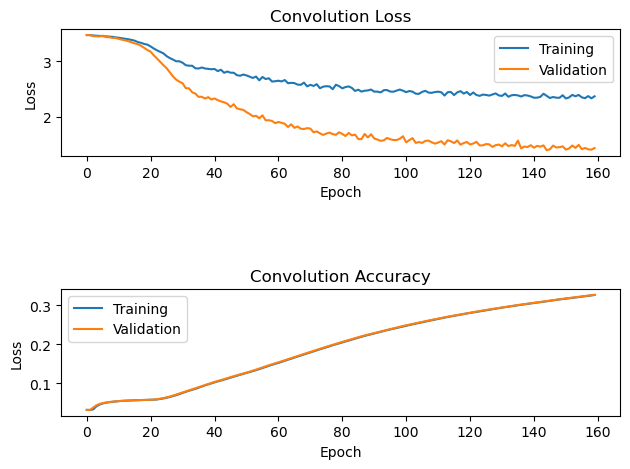

In [28]:
# Plot History in one image
plt.figure(1)

# Loss history
plt.subplot(211)
plt.plot(history.history['loss'],label='Training')
plt.plot(history.history['val_loss'],label='Validation')
plt.legend()

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Convolution Loss')

# Accuracy history
plt.subplot(212)
plt.plot(history.history['ContrastiveAccuracy'],label='Training')
plt.plot(history.history['val_ContrastiveAccuracy'],label='Validation')
plt.legend()

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Convolution Accuracy')

plt.tight_layout(h_pad = 5.0)
plt.savefig('history.png')
plt.show()

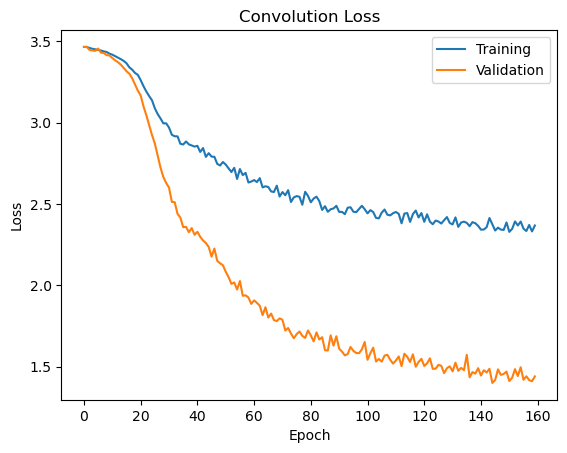

In [29]:
# Plot Loss in individual image
plt.plot(history.history['loss'],label='Training')
plt.plot(history.history['val_loss'],label='Validation')
plt.legend()

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Convolution Loss')

plt.savefig('history_loss.png')
plt.show()

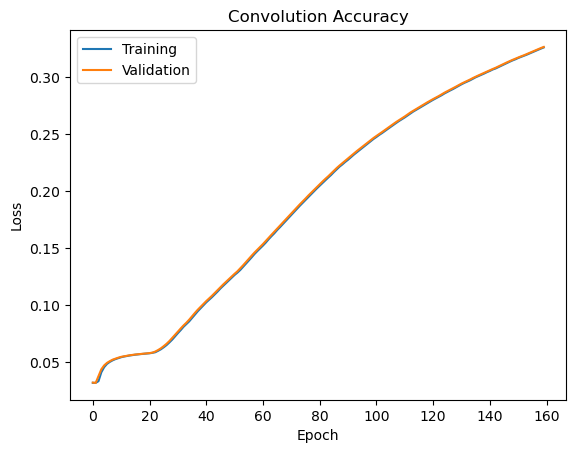

In [30]:
# Plot Accuracy in individual image
plt.plot(history.history['ContrastiveAccuracy'],label='Training')
plt.plot(history.history['val_ContrastiveAccuracy'],label='Validation')
plt.legend()

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Convolution Accuracy')

plt.savefig('history_acc.png')
plt.show()

### Obtaining Realistic Accuracies

In [31]:
offset = 0
n_comp = 100

In [32]:
# update with notes to compare
cm((x_val[0:1],x_train[offset:offset+n_comp]))

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[-2.82008314e+00,  1.12296124e+01, -8.15159798e+00,
         1.85651875e+01, -1.75881423e-02, -3.05893922e+00,
        -1.21831453e+00, -4.00619650e+00, -1.21730077e+00,
         1.13263702e+01, -5.02497435e-01,  3.33142424e+00,
        -3.22927833e+00,  6.78884745e-01, -1.22537220e+00,
         4.45641994e+00, -6.56954646e-01,  4.85529214e-01,
         5.97560310e+00,  4.03538322e+00, -7.95015144e+00,
         6.36868620e+00,  7.39794970e+00,  1.85243702e+01,
        -5.49095213e-01, -2.83950734e+00, -6.82248259e+00,
        -3.44727540e+00, -2.45547009e+00, -1.18747163e+00,
         1.43577397e-01,  2.70928383e+00,  1.06819363e+01,
         2.16638589e+00,  1.32523317e+01,  1.56110942e+00,
         4.59947538e+00,  8.74372387e+00, -3.17382455e+00,
         7.03214502e+00, -1.12699485e+00, -1.24367940e+00,
         1.17865200e+01,  5.11352396e+00,  8.51791024e-01,
        -2.01230764e+00, -4.55369473e-01, -1.89548373e-01,
      

In [33]:
y_val[0:1]

array([7], dtype=uint8)

In [34]:
y_train[np.argmax(cm((x_val[0:1],x_train[offset:offset+n_comp])))+offset]

1

In [35]:
accuracy = 0.0
n = 10
with open("10_accuracy.txt", 'w') as file:
    print("True\tPred")
    file.write("True\tPred" + '\n')
    for i in range(n):
        true = y_val[i] 
        pred = y_train[np.argmax(cm((x_val[i:i+1], x_train[offset:offset+n_comp])))+offset]
        print(true, '\t', pred, end = '')
        file.write(str(true) + '\t\t' + str(pred))
        if (y_val[i] == y_train[np.argmax(cm((x_val[i:i+1], x_train[offset:offset+n_comp])))+offset]):
            accuracy+= 1.0
            print("\t\u2714\n")
            file.write("\t\t\u2714\n")
        else:
            print('\n')
            file.write('\n')

    accuracy /= n
    print(f"Accuracy: {accuracy*100}%")
    file.write(f"Accuracy: {accuracy*100}%\n")

True	Pred
7 	 1

2 	 0

1 	 7

0 	 0	✔

4 	 4	✔

1 	 1	✔

4 	 4	✔

9 	 3

5 	 5	✔

9 	 8

Accuracy: 50.0%


In [36]:
accuracy = 0.0
n = y_val.shape[0]
print(n, "computations to make . . .")
for i in range(n):
   # print(y_val[i:i+1],end='\t')
    #print(y_train[np.argmax(cm((x_val[i:i+1], x_train[offset:offset+n_comp])))+offset])
    if (i % (n / 10) == 0 or i == n - 1):
        print(f"\rProgress: {i}/{n} ({(i/n)*100:.2f}%)", end="")  # Update the progress
    if (y_val[i] == y_train[np.argmax(cm((x_val[i:i+1], x_train[offset:offset+n_comp])))+offset]):
        accuracy+= 1.0

accuracy /= n
print(f"\nFinal Accuracy: {accuracy*100}%")
with open("final_accuracy.txt", 'w') as file:
    file.write(f"Final Accuracy: {accuracy*100}%\n")

10000 computations to make . . .
Progress: 9999/10000 (99.99%)
Final Accuracy: 42.36%
